# Fuel Performance Data Set

**Inputs**

- `fuel_dens`: Fuel density ($\frac{kg}{m^3}$)
- `porosity`: Porosity 
- `clad_thick`: Cladding thickness ($m$)
- `pellet_OD`: Pellet outer diameter ($m$)
- `pellet_h`: Pellet height ($m$)
- `gap_thick`: Gap thickness ($m$)
- `inlet_T`: Inlet temperature ($K$)
- `enrich`: U-235 enrichment
- `rough_fuel`: Fuel roughness ($m$)
- `rough_clad`: Clad rouchness ($m$)
- `ax_pow`: Axial power
- `clad_T`: Cladding surface temperature ($K$)
- `pressure`: Pressure ($Pa$)

**Outputs**

- `fis_gas_produced`: Fission gas production ($mol$)
- `max_fuel_centerline_temp`: Max fuel centerline temperature $K$
- `max_fuel_surface_temp`: Max fuel surface temperature $K$
- `radial_clad_dia`: Radial cladding diameter displacement after irradiation $m$

This data set consists of 13 inputs and 4 outputs with 400 data points. This data originates from [1] and a graphical representation is provided below. Case 1 from the pellet-caldding mechanical interaction (PCMI) benchmark [2] was selected for the data set. This benchmark simulates a beginning of life (BOL) ramp of a 10 pellet pressurized water reactor (PWR) fuel rod to an average linear heat rate of 40 kW/m. The inner and outer cladding diameters are reduced such that the fuel-clad interaction occurs during the ramp time. Axial profiles of power and rod surface temperature were assumed to be uniform at $330^{\circ}C$. The 13 input parameters were uniformly randomly sampled independently within their uncertainty bounds and simulated in BISON. The rod response was recorded in 4 outputs.

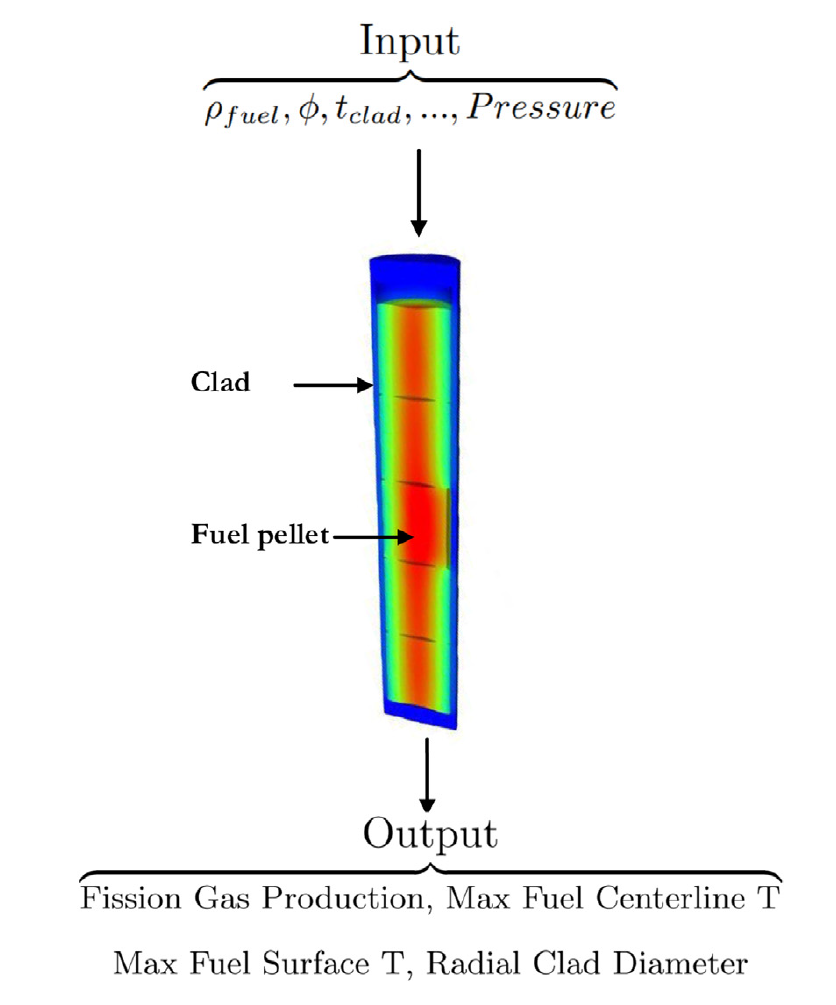

In [15]:
import pyMAISE as mai
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import uniform, randint
from sklearn.model_selection import ShuffleSplit

# Plot settings
matplotlib_settings = {
    "font.size": 14,
    "legend.fontsize": 12,
}
plt.rcParams.update(**matplotlib_settings)

## pyMAISE Initialization

First we initialize pyMAISE with the following 4 parameters:

- `verbosity`: 0 $\rightarrow$ pyMAISE prints no outputs,
- `random_state`: None $\rightarrow$ No random seed is set,
- `test_size`: 0.3 $\rightarrow$ 30% of the data is used for testing,
- `num_configs_saved`: 5 $\rightarrow$ The top 5 hyper-parameter configurations are saved for each model.

With pyMAISE initialized we can load the preprocessor for this data set using `load_fp()`.

In [16]:
global_settings = mai.settings.init()
preprocessor = mai.load_fp()

As stated the data set consists of 13 inputs:

In [17]:
preprocessor.inputs.head()

,fuel_dens,porosity,clad_thick,pellet_OD,pellet_h,gap_thick,inlet_T,enrich,rough_fuel,rough_clad,ax_pow,clad_T,pressure
0,10466,0.040527,0.000571,0.004104,0.013077,0.000019,292.36,0.044852,0.000002,3.890000e-07,0.99967,602.72,15504000
1,10488,0.041780,0.000570,0.004096,0.014227,0.000019,291.33,0.044942,0.000002,4.170000e-07,0.98741,602.81,15591000
2,10434,0.058323,0.000568,0.004094,0.013923,0.000019,293.35,0.044889,0.000002,3.670000e-07,0.99225,620.33,15510000
3,10449,0.038379,0.000572,0.004093,0.013976,0.000019,293.29,0.044937,0.000002,3.250000e-07,1.02650,610.91,15382000
4,10429,0.038438,0.000568,0.004096,0.013787,0.000019,291.81,0.044849,0.000002,4.360000e-07,0.99289,597.05,15583000


and 4 outputs with 400 total data points:

In [18]:
preprocessor.outputs.head()

,fis_gas_produced,max_fuel_centerline_temp,max_fuel_surface_temp,radial_clad_dia
0,0.000029,1569.699310,699.613033,0.000019
1,0.000032,1559.465162,699.976191,0.000019
2,0.000031,1632.394103,712.771506,0.000020
3,0.000032,1613.399315,710.114032,0.000020
4,0.000031,1542.540705,694.956854,0.000018


Prior to constructing any models we can get a surface understanding of the data set with a correlation matrix.

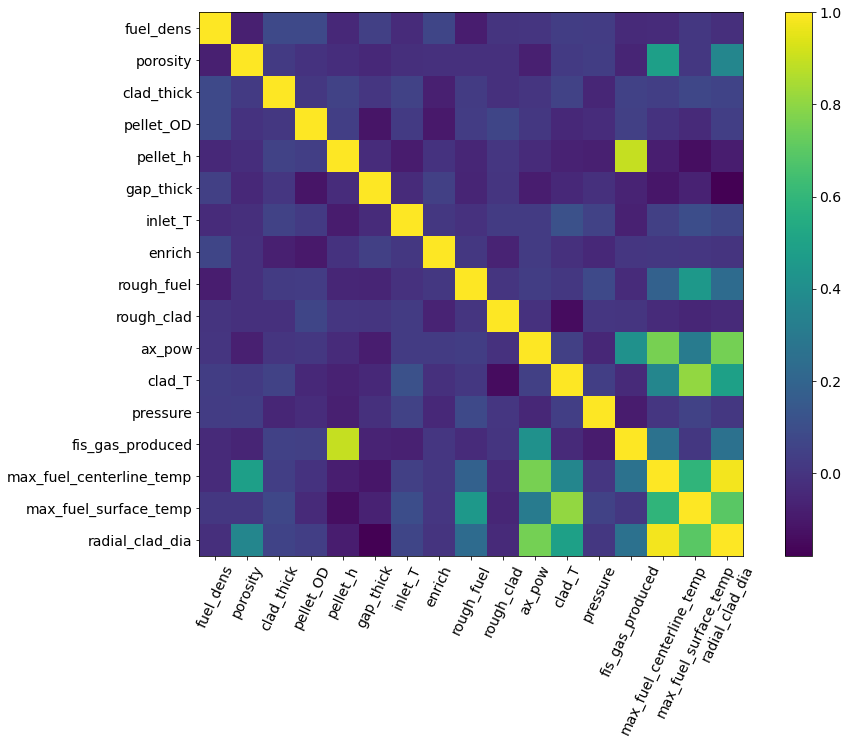

In [19]:
fig, ax = plt.subplots(figsize=(15,10))
fig, ax = preprocessor.correlation_matrix(fig=fig, ax=ax)

There is a positive correlation between axial power and cladding temperature with max fuel centerline temperature, max fuel surface temperature, and radial cladding diameter. Additionally, the fission gas production correlates with pellet height.

The final step of the pyMAISE initialization process is data scaling. For this data set we will use min-max scaling.

In [20]:
data = preprocessor.min_max_scale()

## Model Initialization

We will examine the performance of 6 models in this data set:

- Linear regression: `linear`,
- Lasso regression: `lasso`,
- Decision tree regression: `dtree`,
- Random forest regression: `rforest`,
- K-nearest neighbors regression: `knn`,
- Sequential dense neural networks: `nn`.

For hyper-parameter tuning each model must be initialized. We will use the Scikit-learn defaults for the classical ML models (`linear`, `lasso`, `dtree`, `rforest`, and `knn`); therefore, they are only specified in the `models` parameter of the `model_settings` dictionary. However, we must specify `nn` model parameters that define the layers, optimizer, and training.

In [23]:
model_settings = {
    "models": ["linear", "lasso", "dtree", "knn", "rforest", "nn"],
    "nn": {
        # Sequential
        "num_layers": 4,
        "dropout": True,
        "rate": 0.5,
        "validation_split": 0.15,
        "loss": "mean_absolute_error",
        "metrics": ["mean_absolute_error"],
        "batch_size": 8,
        "epochs": 50,
        "warm_start": True,
        "jit_compile": False,
        # Starting Layer
        "start_num_nodes": 100,
        "start_kernel_initializer": "normal",
        "start_activation": "relu",
        "input_dim": preprocessor.inputs.shape[1], # Number of inputs
        # Middle Layers
        "mid_num_node_strategy": "linear", # Middle layer nodes vary linearly from 'start_num_nodes' to 'end_num_nodes'
        "mid_kernel_initializer": "normal",
        "mid_activation": "relu",
        # Ending Layer
        "end_num_nodes": preprocessor.outputs.shape[1], # Number of outputs
        "end_activation": "linear",
        "end_kernel_initializer": "normal",
        # Optimizer
        "optimizer": "adam",
        "learning_rate": 5e-4,
    },
}
tuning = mai.Tuning(data=data, model_settings=model_settings)

## Hyper-parameter Tuning

We will use random search for the hyper-parameter tuning of the classical models (`lasso`, `dtree`, `rforest`, and `knn`) through the `random_search` function. `linear` will be manually fit with the Scikit-learn defaults. For each classical model 300 models will be produced with randomly sampled parameter configurations. For `nn`, bayesian search is used to optimize the hyper-parameters in 50 iterations through the `bayesian_search` function. Bayesian search is appealing for `nn` as their training can be computationally expensive. To further reduce the computational cost of `nn` we specify only 10 epochs which will produce less than performant models but show the optimal parameters. For both search methods we use cross-validation to reduce bias in the models from the data set. The hyper-parameter search spaces are defined in the `random_search_spaces` and `bayesian_search_spaces` dictionaries.

In [24]:
random_search_spaces = {
    "lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "dtree": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "rforest": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "knn": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}
bayesian_search_spaces = {
    "nn": {
        "mid_num_node_strategy": ["constant", "linear"],
        "batch_size": [8, 64],
        "learning_rate": [1e-5, 0.001],
        "num_layers": [2, 6],
        "start_num_nodes": [25, 300],
    },
}

start = time.time()
random_search_configs = tuning.random_search(
    param_spaces=random_search_spaces, 
    models=["linear"] + list(random_search_spaces.keys()), 
    n_iter=300, 
    cv=ShuffleSplit(n_splits=5, test_size=0.25, random_state=global_settings.random_state),
)
bayesian_search_configs = tuning.bayesian_search(
    param_spaces=bayesian_search_spaces,
    models=bayesian_search_spaces.keys(),
    n_iter=50,
    cv=5,
)
stop = time.time()
print("Hyper-parameter tuning took " + str((stop - start) / 60) + " minutes to process.")

Hyper-parameter tuning search space was not provided for linear, doing manual fit
Hyper-parameter tuning took 20.43228469292323 minutes to process.


We can understand the hyper-parameter tuning of Bayesian search from the convergence plot.

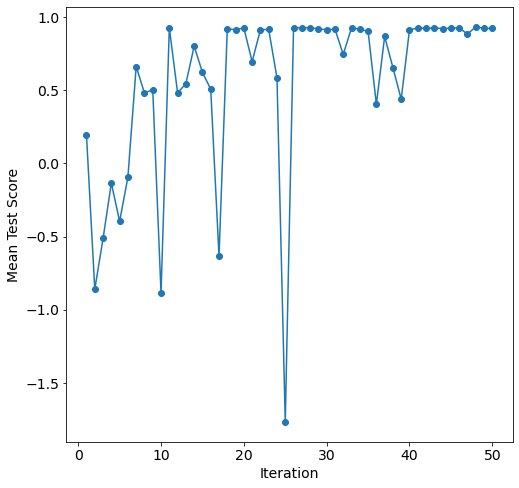

In [25]:
fig, ax = plt.subplots(figsize=(8,8))
ax = tuning.convergence_plot(model_types="nn")

Fewer than 30 iterations were required to converge to the optimal parameter configurations.

## Model Post-processing

Now that the top `num_configs_saved` saved, we can pass these models to the `PostProcessor` for model comparison and analysis. To improve the `nn` performance we can pass an updated epochs parameter. Using 200 epochs should improve fitting at higher computational cost.

In [26]:
new_model_settings = {
    "nn": {"epochs": 200}
}
postprocessor = mai.PostProcessor(
    data=data, 
    models_list=[random_search_configs, bayesian_search_configs], 
    new_model_settings=new_model_settings
)

To compare the performance of these models we will compute 4 metrics for both the training and testing data: 

- mean squared error `MSE` $=\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2$, 
- root mean squared error `RMSE` $=\sqrt{\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2}$,
- mean absolute error `MAE` = $=\frac{1}{n}\sum^n_{i = 1}|y_i - \hat{y_i}|$,
- and r-squared `R2` $=1 - \frac{\sum^n_{i = 1}(y_i - \hat{y_i})^2}{\sum^n_{i = 1}(y_i - \bar{y_i})^2}$,

where $y$ is the actual outcome, $\bar{y}$ is the average outcome, $\bar{y}$ is the model predicted outcome, and $n$ is the number of observations.

In [27]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
0,linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.980292,0.014451,0.000533,0.023088,0.974592,0.015081,0.000579,0.024057
1,lasso,{'alpha': 0.0001477953555587645},0.980077,0.014660,0.000540,0.023229,0.974202,0.015313,0.000589,0.024278
2,lasso,{'alpha': 0.0001742039271953711},0.980007,0.014713,0.000542,0.023274,0.974096,0.015387,0.000592,0.024339
3,lasso,{'alpha': 0.00017943003633537601},0.979992,0.014724,0.000542,0.023284,0.974078,0.015401,0.000593,0.024350
4,lasso,{'alpha': 0.00018930287736374705},0.979964,0.014746,0.000543,0.023302,0.974043,0.015429,0.000594,0.024371
5,lasso,{'alpha': 0.00022031892962763334},0.979867,0.014820,0.000546,0.023365,0.973930,0.015509,0.000597,0.024439
22,nn,"{'batch_size': 16, 'learning_rate': 0.00090966...",0.977834,0.018056,0.000635,0.025203,0.968801,0.019774,0.000786,0.028038
24,nn,"{'batch_size': 13, 'learning_rate': 0.00077997...",0.975848,0.019738,0.000700,0.026456,0.965882,0.021457,0.000867,0.029446
21,nn,"{'batch_size': 13, 'learning_rate': 0.001, 'mi...",0.975959,0.020035,0.000720,0.026828,0.965187,0.021521,0.000883,0.029715
25,nn,"{'batch_size': 15, 'learning_rate': 0.001, 'mi...",0.967425,0.024973,0.000976,0.031247,0.953627,0.027921,0.001249,0.035346


Given the top performing models are `linear` and `lasso` this data set's outputs are linear with their inputs. `nn` also performs well with all models close to 0.95. Performance quickly drops off with `rforest`, `knn`, and `dtree`.

We can see the parameters of each model with the best `Test R2` with `get_params`.

In [28]:
for model in model_settings["models"]:
    print(postprocessor.get_params(model_type=model), "\n")

  Model Types  copy_X  fit_intercept n_jobs  positive
0      linear    True           True   None     False 

  Model Types     alpha
0       lasso  0.000148 

  Model Types  max_depth max_features  min_samples_leaf  min_samples_split
0       dtree         41         None                 2                  8 

  Model Types  leaf_size  n_neighbors  p   weights
0         knn          4            6  2  distance 

  Model Types criterion max_features  min_samples_leaf  min_samples_split  \
0     rforest   poisson         None                 1                  4   

   n_estimators  
0           161   

  Model Types  batch_size  learning_rate mid_num_node_strategy  num_layers  \
0          nn          16        0.00091              constant           2   

   start_num_nodes  
0              300   



We can visualize the performance of each model with diagonal validation plots. These plots show the predicted output to the actual output. For the plots below we will do max fuel centerline temperature.

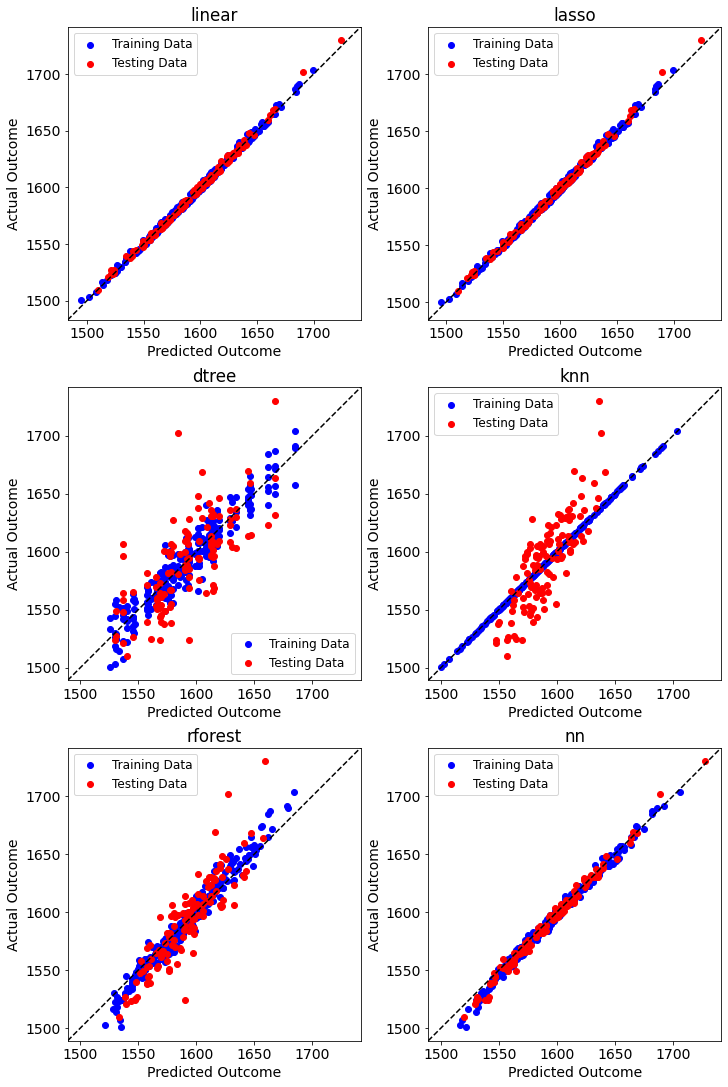

In [29]:
models = np.array([["linear", "lasso"], ["dtree", "knn"], ["rforest", "nn"]])

output = ["max_fuel_centerline_temp"]

fig = plt.figure(constrained_layout=fig, figsize=(10,15))
gs = GridSpec(models.shape[0], models.shape[1], figure=fig)
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        if models[i, j] != None:
            ax = fig.add_subplot(gs[i, j])
            ax = postprocessor.diagonal_validation_plot(
                model_type=models[i, j], 
                yscaler=preprocessor.yscaler, 
                y=output,
            )
            ax.set_title(models[i, j])

With these plots we can see the narrow spread of `linear` and `lasso` to $y = x$, the best possible performance of a model. Additionally, `knn` appears to be overfit to the training data set and the preditions of `nn` under 1550 K under-approximate the max fuel centerline temperature. 

Similarly, the `validation_plot` function produces validation plots that show the absolute relative error for each max fuel centerline temperature prediction.

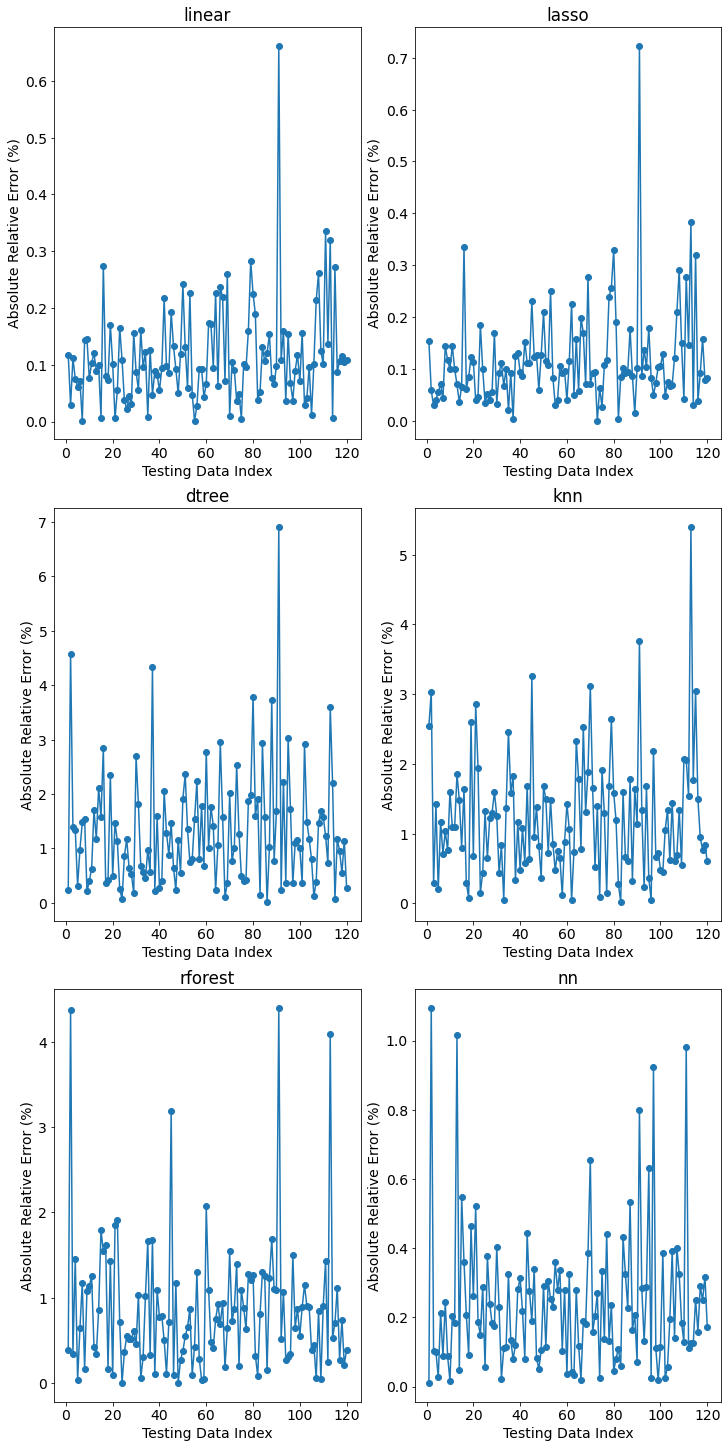

In [30]:
fig = plt.figure(constrained_layout=fig, figsize=(10,20))
gs = GridSpec(models.shape[0], models.shape[1], figure=fig)
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        if models[i, j] != None:
            ax = fig.add_subplot(gs[i, j])
            ax = postprocessor.validation_plot(
                model_type=models[i, j], 
                yscaler=preprocessor.yscaler, 
                y=output,
            )
            ax.set_title(models[i, j])

The performance gap of the linear model to the others is evident in the magnitude of the relative error. There is also one common outlier between `linear`, `lasso`, `dtree`, and `rforest` between 80 and 100. 

Finally, the learning curve of the most performant `nn` is shown by `nn_learning_plot`.

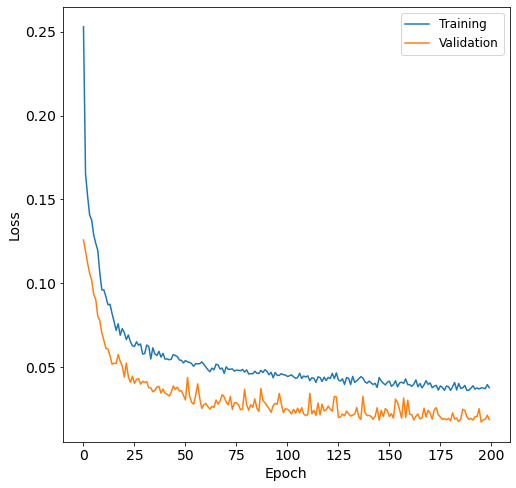

In [31]:
fig, ax = plt.subplots(figsize=(8,8))
ax = postprocessor.nn_learning_plot()

The validation curve is below the training curve; therefore, the `nn` is not overfit. 

## References

1. M. I. RADAIDEH and T. KOZLOWSKI, “Surrogate modeling of advanced computer simulations using deep Gaussian processes,” Reliability Engineering System Safety, 195, 106731 (2020).
2. Rossiter, G., Massara, S., & Amaya, M. (2016). OECD/NEA benchmark on pellet-clad mechanical interaction modelling with fuel performance codes (AECL-CW--124600-CONF-004). Canada

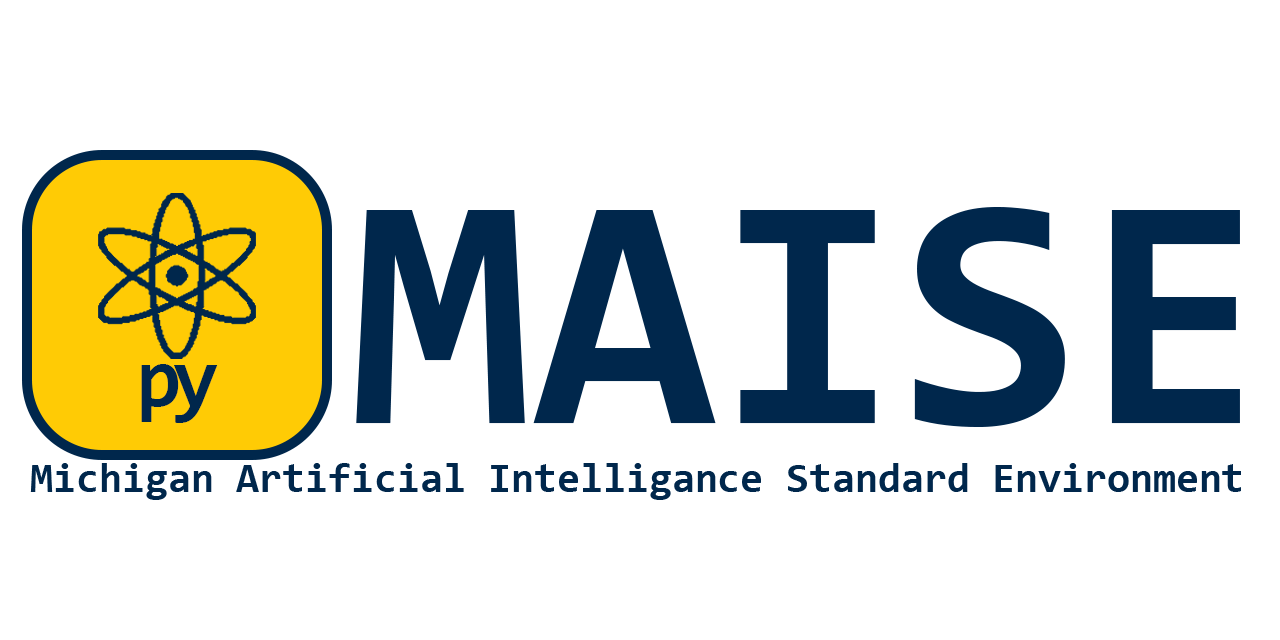